# Assignment 1  
Mohammad Rashiqul Alam  
malam25@illinois.edu  

### Load All Images to Notebook

In [26]:
# Modules
import os
import numpy as np
import matplotlib.pyplot as plt
from   PIL import Image


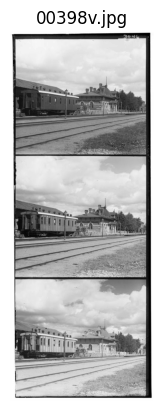

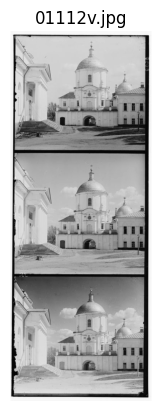

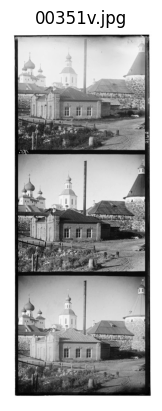

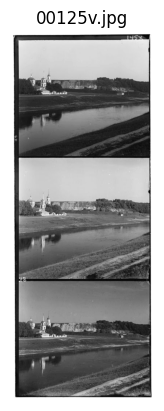

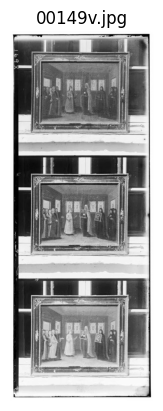

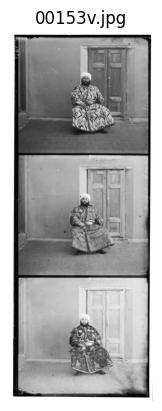

In [27]:
# Load images from directory
directory   = "/home/rashiqul/workspace/ece549/picture/data/"
image_files = [file for file in os.listdir(directory) if file.lower().endswith('.jpg')]

# Display aa 6 images
for file in image_files:
    path  = os.path.join(directory, file)
    image = Image.open(path)
    plt.imshow(image, cmap='gray')
    plt.title(file)
    plt.axis('off')
    plt.show()

### Image Cropping

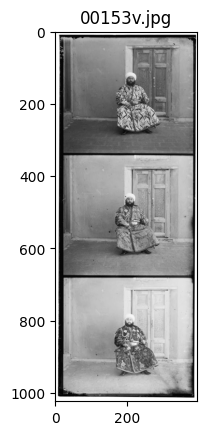

In [28]:
# Let's work with the first image in the list
image_path = os.path.join(directory, image_files[0])
image0 = Image.open(path)
plt.imshow(image0, cmap='gray')
plt.title(file)
plt.show()

In [29]:
# Normalize the image to [0, 1] range and display it
image0 = np.array(image0) / 255.0

# Print the image dimension, size and the matrix
print(f"Image dimensions: {image0.shape}")
print(f"Image size: {image0.size}")
print(f"Image matrix:\n{image0}")

Image dimensions: (1024, 394)
Image size: 403456
Image matrix:
[[0.99607843 0.99607843 0.99607843 ... 0.99607843 1.         1.        ]
 [0.99607843 0.99607843 0.99607843 ... 0.99607843 1.         1.        ]
 [0.99607843 0.99607843 0.99607843 ... 0.99607843 1.         1.        ]
 ...
 [1.         1.         1.         ... 0.99607843 1.         0.60392157]
 [1.         1.         1.         ... 0.99607843 1.         0.59215686]
 [1.         1.         1.         ... 0.99607843 1.         0.58431373]]


In [30]:
# Calculate the height of the image
height = image0.shape[0]
# Calculate the height per channel
height_per_channel = int(height / 3)

# Print the height per channel
print(f"Height per channel: {height_per_channel}") 

Height per channel: 341


In [31]:
# Slice the image into its three color channels using the calculated height_per_channel
top_slice_channel     = image0[0 : height_per_channel, :]
middle_slice_channel  = image0[height_per_channel : 2 * height_per_channel, :]
bottom_slice_channel  = image0[2 * height_per_channel : 3 * height_per_channel, :]

Top Dimension: (341, 394)


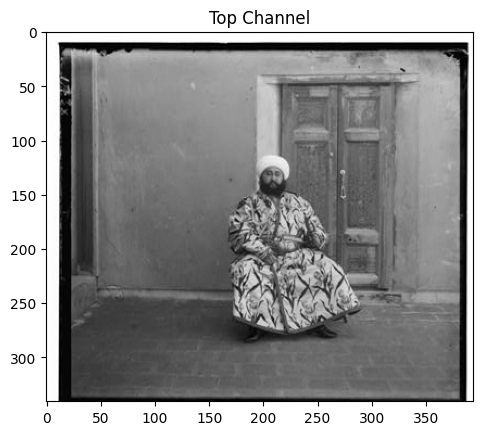

Middle Dimension: (341, 394)


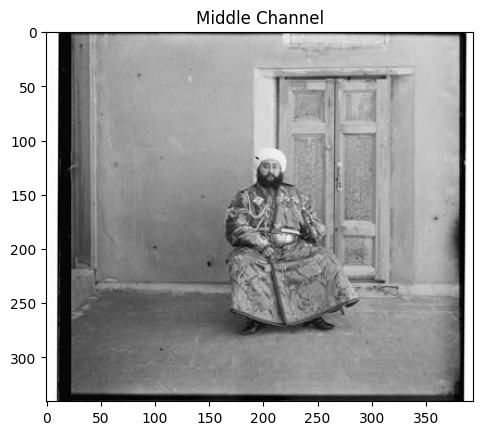

Bottom Dimension: (341, 394)


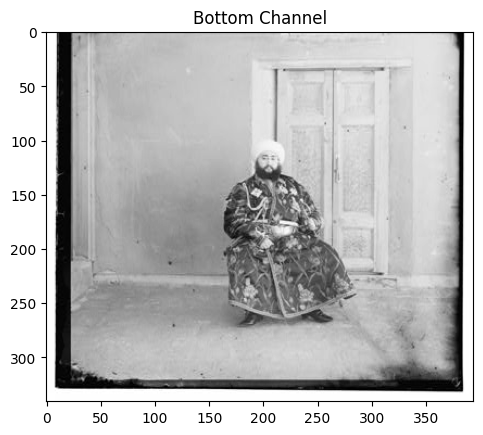

In [32]:
# Display the channels
for channel, slice in zip([top_slice_channel, middle_slice_channel, bottom_slice_channel], ['Top', 'Middle', 'Bottom']):
    plt.imshow(channel, cmap='gray')
    plt.title(f"{slice} Channel")
    print(f"{slice} Dimension: {channel.shape}")
    plt.show()

### Remove Borders

In [33]:
# Borders and clean-up
# There are black borders at the very top, bottom, left, and right of the image.
# These borders can be removed by slicing the image appropriately.
# Let's assume the borders are 8% wide on each side (taking a number in between 5-10%).

def remove_borders(channel, border_percent=0.08):
    """
    Function to remove borders from a given channel.
    """
    height, width = channel.shape
    # Get border sizes 
    top     = int(height * border_percent)
    bottom  = int(height * (1 - border_percent))
    left    = int(width * border_percent)
    right   = int(width * (1 - border_percent))
    # Crop the channel
    cropped = channel[top:bottom, left:right]
    
    return cropped


Top Dimension after border removal on white canvas: (286, 331)


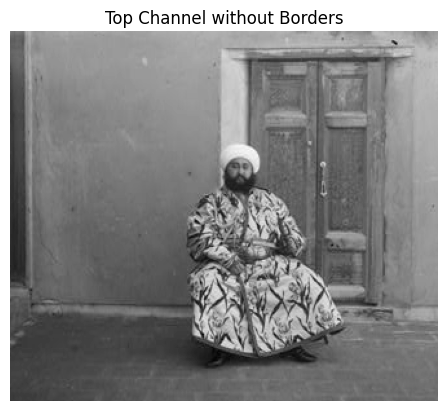

Middle Dimension after border removal on white canvas: (286, 331)


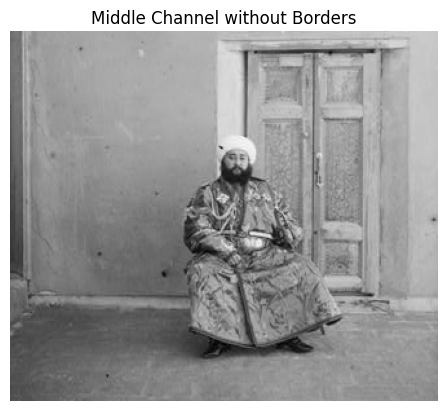

Bottom Dimension after border removal on white canvas: (286, 331)


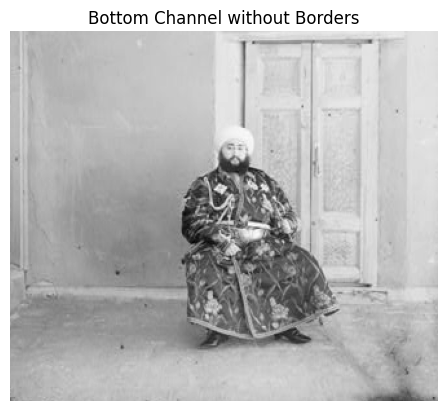

In [34]:
# Remove borders from each channel
top_slice_channel    = remove_borders(top_slice_channel)
middle_slice_channel = remove_borders(middle_slice_channel)
bottom_slice_channel = remove_borders(bottom_slice_channel)

# Display the channels after border removal
for channel, slice in zip([top_slice_channel, middle_slice_channel, bottom_slice_channel], ['Top', 'Middle', 'Bottom']):
    # Create a white canvas slightly larger than the cropped image
    h, w = channel.shape
    # Create a white canvas slightly larger than the cropped image
    padding = 50
    canvas_height = h + 2 * padding
    canvas_width  = w + 2 * padding
    # White canvas
    canvas = np.ones((canvas_height, canvas_width))  

    # Center the cropped image
    start_row = padding
    start_col = padding
    canvas[start_row : start_row + h, start_col : start_col + w] = channel
    
    # Display
    plt.imshow(channel, cmap='gray')
    plt.title(f"{slice} Channel without Borders")
    print(f"{slice} Dimension after border removal on white canvas: {channel.shape}")
    plt.axis('off')
    plt.show()

### Channel Registration

In [35]:
# Assume the middle channel is the reference channel
reference_channel = middle_slice_channel

# Define a search window for alignment (e.g., 15 pixels in each direction)
search_window = 15

In [36]:
# Define a function to compute the Sum of Squared Differences (SSD)
def align_channel(reference, moving, search_window):
    """
    Align the moving channel to the reference channel using SSD within a search window.
    """
    h, w = reference.shape
    best_score = np.inf
    best_dx = 0
    best_dy = 0
    
    # Iterate over possible shifts within the search window
    for dy in range(-search_window, search_window + 1):
        for dx in range(-search_window, search_window + 1):
            # Find the overlap region
            # Rows
            ref_y0 = max(0, dy)
            ref_y1 = min(h, h + dy)
            mov_y0 = max(0, -dy)
            mov_y1 = min(h, h - dy)
            # Columns
            ref_x0 = max(0, dx)
            ref_x1 = min(w, w + dx)
            mov_x0 = max(0, -dx)
            mov_x1 = min(w, w - dx)

            # Only process if there's an overlap
            if ref_y1 > ref_y0 and ref_x1 > ref_x0:
                # Extract the overlapping regions
                ref_overlap  = reference[ref_y0 : ref_y1, ref_x0 : ref_x1]
                mov_overlap  = moving[mov_y0 : mov_y1, mov_x0 : mov_x1]

                # Compute SSD
                rp = ref_overlap - ref_overlap.mean()
                mp = mov_overlap - mov_overlap.mean()
                ssd = np.sum((rp - mp) ** 2)

                # Keep the best score and shift
                if ssd < best_score:
                    best_score = ssd
                    best_dx = dx 
                    best_dy = dx
    
    # Build align moving channel by applying best shift with zero padding and no warp-around
    algined_channel = np.zeros_like(moving)
    ref_y0 = max(0, best_dy)
    ref_y1 = min(h, h + best_dx)
    ref_x0 = max(0, best_dx)
    ref_x1 = min(w, w + best_dx)
    mov_y0 = max(0, -best_dy)
    mov_y1 = min(h, h - best_dy)
    mov_x0 = max(0, -best_dx)
    mov_x1 = min(w, w - best_dx)

    if ref_y1 > ref_y0 and ref_x1 > ref_x0:
        algined_channel[ref_y0 : ref_y1, ref_x0 : ref_x1] = moving[mov_y0 : mov_y1, mov_x0 : mov_x1]
    
    # Return both the shift (reporting requirement) and the aligned image
    return (best_dx, best_dy), algined_channel, best_score

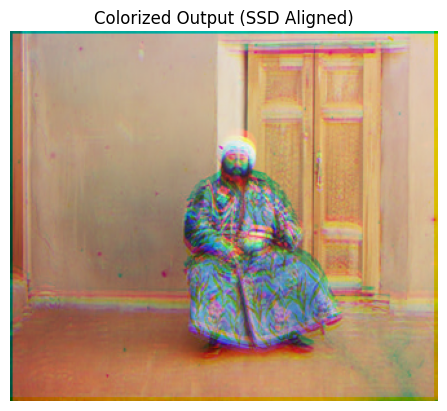

In [38]:
# Align the bottom channel to the middle (reference) channel
(shift, aligned_bottom, _) = align_channel(middle_slice_channel, bottom_slice_channel, search_window)

# Align the top channel to the middle (reference) channel
(shift, aligned_top, _) = align_channel(middle_slice_channel, top_slice_channel, search_window)

# Stack channels (assuming top=Blue, middle=Green, aligned_bottom=Red)
rgb_image = np.dstack([aligned_bottom, middle_slice_channel, aligned_top])
plt.imshow(rgb_image)
plt.title("Colorized Output (SSD Aligned)")
plt.axis('off')
plt.show()

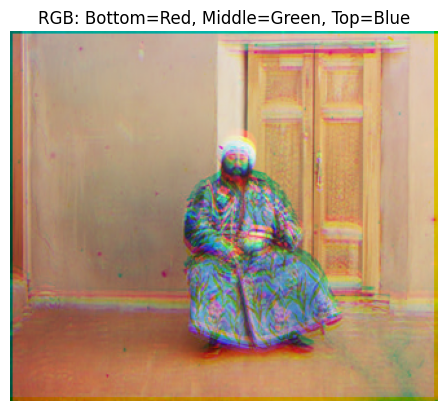

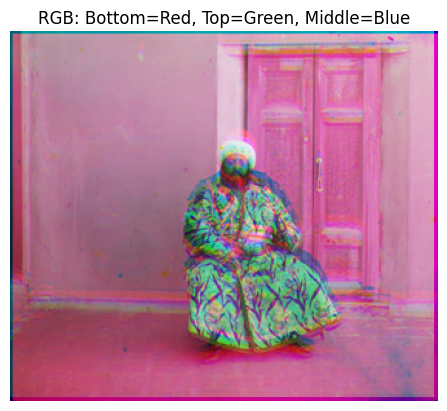

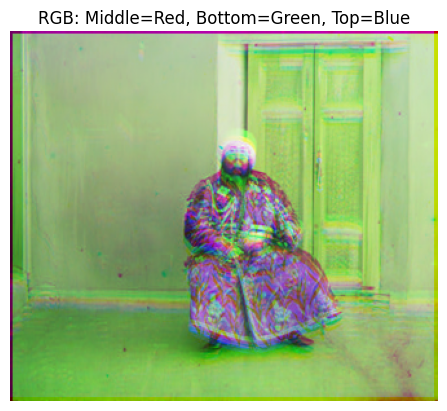

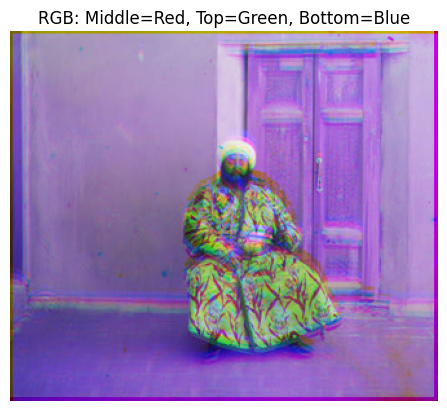

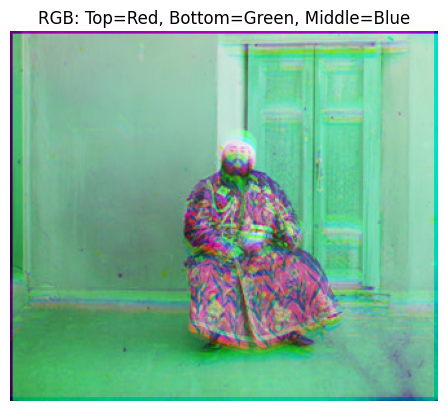

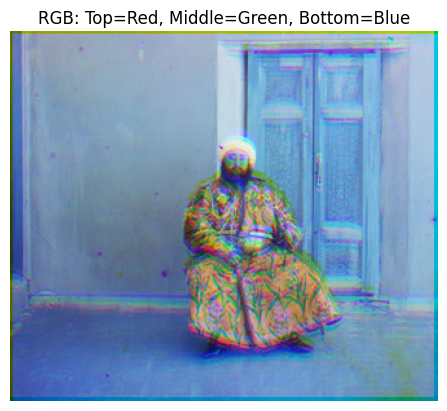

In [ ]:
# Pefrorm alignment for all permutations of channel assignments
import itertools

# Channels to permute
channels = [aligned_bottom, middle_slice_channel, aligned_top]
labels = ['Bottom', 'Middle', 'Top']
colors = ['Red', 'Green', 'Blue']

# Display all permutations
for perm, label_perm in zip(itertools.permutations(channels), itertools.permutations(labels)):
    rgb_image = np.dstack(perm)
    plt.imshow(rgb_image)
    plt.title(f"RGB: {label_perm[0]}={colors[0]}, {label_perm[1]}={colors[1]}, {label_perm[2]}={colors[2]}")
    plt.axis('off')
    plt.show()